In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib as mpl
import polars as pl
from cyvcf2 import VCF
from tqdm import tqdm

plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['figure.facecolor'] = "w"
plt.rcParams['figure.autolayout'] = True

from mpl_toolkits.axes_grid1 import make_axes_locatable

%matplotlib inline

In [2]:
%%bash 
mkdir -p plots/
mkdir -p results/tables/
mkdir -p data/tables/
mkdir -p data/metadata/
mkdir -p data/vcf/eQTL/; mkdir -p data/vcf/sQTL/

# Setting up QTL tables 
cd data/tables/; 
wget -q -nc -O eQTL_finemapping.leadVariant_aFCn.MAGE.v1.0.txt.gz  https://www.dropbox.com/scl/fi/zhkn9quyg7f6ffc7ysl2t/eQTL_finemapping.leadVariant_aFCn.MAGE.v1.0.txt.gz?rlkey=nb36tv7zykxl7c3gynaebrubt&dl=0;
wget -q -nc -O sQTL_finemapping.geneMerged.leadVariant.MAGE.v1.0.txt.gz https://www.dropbox.com/scl/fi/1dky9y1eml17iz2jscasl/sQTL_finemapping.geneMerged.leadVariant.MAGE.v1.0.txt.gz?rlkey=yt6e7zff5vyet1px0fzbbxzpv&dl=0
cd ../../

# Setting up sample metadata 
cd data/metadata; 
wget -q -nc -O sample_metadata.tsv https://www.dropbox.com/scl/fi/w3w8p3sl3apu95ipv0mo4/sample_metadata.tsv?rlkey=le2f1d5u2856vabgqop1vphf6&dl=0
cd ../../

# Setting up QTL vcf files
cd data/vcf/eQTL/; wget -q -nc -O total_variants.vcf.gz https://www.dropbox.com/scl/fi/xa1gx2g78g824sayrfse4/total_variants.vcf.gz?rlkey=u45h3h17bwsgme6psuvsn6wwz&dl=0
cd ../../../
cd data/vcf/sQTL/; wget -q -nc -O total_variants.vcf.gz https://www.dropbox.com/scl/fi/ee8j28yd0y4qlhojx0h6q/total_variants.vcf.gz?rlkey=00e037n2lg1fwbmftlpi3hkzg&dl=0



In [3]:
# Reading in the eqtl dataframe ... 
eqtl_df = pl.read_csv('data/tables/eQTL_finemapping.leadVariant_aFCn.MAGE.v1.0.txt.gz', infer_schema_length=10000, null_values=['NA'], separator="\t")
eqtl_df.head()

variantChrom,variantPosition,variantRef,variantAlt,variant_kgpID,variant_rsID,ensemblID,geneSymbol,variantPIP,variantCredibleSet,log2_aFC,log2_aFC_error,log2_aFC_c0,log2_aFC_min_95_interv,log2_aFC_plus_95_interv,log2_aFC_c0_min_95_interv,log2_aFC_c0_plus_95_interv
str,i64,str,str,str,str,str,str,f64,str,f64,f64,f64,f64,f64,f64,f64
"""chr1""",19254,"""G""","""C""","""1:19254:G:C""","""rs879460869""","""ENSG00000227232.5""","""WASH7P""",0.985507,"""L3""",-0.578296,0.114464,6.905004,-0.819783,-0.358723,6.874137,6.935882
"""chr1""",48186,"""T""","""G""","""1:48186:T:G""","""rs199900651""","""ENSG00000238009.6""","""RP11-34P13.7""",0.70556,"""L1""",1.088567,0.203861,2.794374,0.658647,1.48237,2.726822,2.861927
"""chr1""",98667,"""T""","""C""","""1:98667:T:C""","""rs377391031""","""ENSG00000227232.5""","""WASH7P""",0.256749,"""L2""",0.535219,0.086314,6.905004,0.35828,0.703772,6.874137,6.935882
"""chr1""",135032,"""G""","""A""","""1:135032:G:A""","""rs148209574""","""ENSG00000269981.1""","""RP11-34P13.16""",0.259833,"""L1""",-1.625592,0.383893,0.857479,-2.604697,-0.924816,0.752156,0.96236
"""chr1""",182631,"""A""","""G""","""1:182631:A:G""","""rs1160932233""","""ENSG00000227232.5""","""WASH7P""",0.999999,"""L1""",0.401197,0.049851,6.905004,0.299288,0.50023,6.874137,6.935882


In [4]:
sqtl_df = pl.read_csv('data/tables/sQTL_finemapping.geneMerged.leadVariant.MAGE.v1.0.txt.gz', infer_schema_length=10000, null_values=['NA'], separator="\t")
sqtl_df.head()

variantChrom,variantPosition,variantRef,variantAlt,variant_kgpID,variant_rsID,ensemblID,geneSymbol,mergedCredibleSet,intronID,intronCredibleSet,intronCS_coverage,intronCS_variantPIP,mergedIntronSets
str,i64,str,str,str,str,str,str,str,str,str,f64,f64,str
"""chr1""",66481,"""TTTATAGA""","""T""","""1:66481:TTTATAGA:T""","""rs1487566709""","""ENSG00000227232.5""","""WASH7P""","""M1""","""chr1:24891:29321:clu_4_-:ENSG0…","""L1""",0.998544,0.225843,"""chr1:24891:29321:clu_4_-:ENSG0…"
"""chr1""",66481,"""TTTATAGA""","""T""","""1:66481:TTTATAGA:T""","""rs1487566709""","""ENSG00000279457.4""","""WASH9P""","""M2""","""chr1:24891:29321:clu_4_-:ENSG0…","""L1""",0.998273,0.225201,"""chr1:24891:29321:clu_4_-:ENSG0…"
"""chr1""",270684,"""C""","""G""","""1:270684:C:G""","""rs143434963""","""ENSG00000237094.12""","""RP4-669L17.4""","""M3""","""chr1:729804:733307:clu_7_-:ENS…","""L1""",0.999747,0.927872,"""chr1:501620:502187:clu_8_-:ENS…"
"""chr1""",270684,"""C""","""G""","""1:270684:C:G""","""rs143434963""","""ENSG00000228327.3""","""RP11-206L10.2""","""M10""","""chr1:729804:733307:clu_7_-:ENS…","""L1""",0.999746,0.927801,"""chr1:729804:733307:clu_7_-:ENS…"
"""chr1""",270684,"""C""","""G""","""1:270684:C:G""","""rs143434963""","""ENSG00000230021.10""","""RP11-206L10.17""","""M11""","""chr1:729804:733307:clu_7_-:ENS…","""L1""",0.999745,0.92736,"""chr1:729804:733307:clu_7_-:ENS…"


In [5]:
# Read in the sample-metadata file
sample_meta_df = pl.read_csv('data/metadata/sample_metadata.tsv', separator='\t')
sample_meta_df.head()

KGP_sample_id,karyotype,superpopulation,population,unrelated
str,str,str,str,bool
"""HG00096""","""XY""","""EUR""","""GBR""",true
"""HG00097""","""XX""","""EUR""","""GBR""",true
"""HG00099""","""XX""","""EUR""","""GBR""",true
"""HG00100""","""XX""","""EUR""","""GBR""",true
"""HG00101""","""XY""","""EUR""","""GBR""",true


In [6]:
# Building the eQTL dataframe for the allele frequencies ... 
eqtl_vcf = 'data/vcf/eQTL/total_variants.vcf.gz'
eqtl_af_df = pl.DataFrame()
for i, p in tqdm(enumerate(sample_meta_df['population'].unique())):
    samples = sample_meta_df.filter((pl.col('population') == p) & pl.col('unrelated'))['KGP_sample_id'].to_numpy().tolist()
    if i == 0:
        ids = []
        af = []
        ac = []
        an = []
        for v in VCF(eqtl_vcf, samples=samples, gts012=True, threads=8):
            ids.append(v.ID)
            af.append(v.aaf)
            ac.append(np.sum(v.gt_types[v.gt_types != 0]))
            an.append(2*v.num_called)
        eqtl_af_df = eqtl_af_df.with_columns(
            pl.Series(ids).alias('variant_kgpID'),
            pl.Series(af).alias(f'AF_{p}'), 
            pl.Series(ac).alias(f'AC_{p}'), 
            pl.Series(an).alias(f'AN_{p}'))
    else:
        af = []
        ac = []
        an = []
        for v in VCF(eqtl_vcf, samples=samples, gts012=True, threads=8):
            af.append(v.aaf)
            ac.append(np.sum(v.gt_types[v.gt_types != 0]))
            an.append(2*v.num_called)
        eqtl_af_df = eqtl_af_df.with_columns(pl.Series(af).alias(f'AF_{p}'), 
                                             pl.Series(ac).alias(f'AC_{p}'), 
                                             pl.Series(an).alias(f'AN_{p}'))
eqtl_af_df.head()

26it [00:31,  1.20s/it]


variant_kgpID,AF_GBR,AC_GBR,AN_GBR,AF_BEB,AC_BEB,AN_BEB,AF_ASW,AC_ASW,AN_ASW,AF_PUR,AC_PUR,AN_PUR,AF_CHB,AC_CHB,AN_CHB,AF_ITU,AC_ITU,AN_ITU,AF_MSL,AC_MSL,AN_MSL,AF_FIN,AC_FIN,AN_FIN,AF_ACB,AC_ACB,AN_ACB,AF_MXL,AC_MXL,AN_MXL,AF_CLM,AC_CLM,AN_CLM,AF_GIH,AC_GIH,AN_GIH,…,AN_YRI,AF_CDX,AC_CDX,AN_CDX,AF_GWD,AC_GWD,AN_GWD,AF_IBS,AC_IBS,AN_IBS,AF_PEL,AC_PEL,AN_PEL,AF_TSI,AC_TSI,AN_TSI,AF_STU,AC_STU,AN_STU,AF_LWK,AC_LWK,AN_LWK,AF_JPT,AC_JPT,AN_JPT,AF_KHV,AC_KHV,AN_KHV,AF_PJL,AC_PJL,AN_PJL,AF_CEU,AC_CEU,AN_CEU,AF_CHS,AC_CHS,AN_CHS
str,f64,i64,i64,f64,i64,i64,f64,i64,i64,f64,i64,i64,f64,i64,i64,f64,i64,i64,f64,i64,i64,f64,i64,i64,f64,i64,i64,f64,i64,i64,f64,i64,i64,f64,i64,i64,…,i64,f64,i64,i64,f64,i64,i64,f64,i64,i64,f64,i64,i64,f64,i64,i64,f64,i64,i64,f64,i64,i64,f64,i64,i64,f64,i64,i64,f64,i64,i64,f64,i64,i64,f64,i64,i64
"""1:19254:G:C""",0.010989,2,182,0.011628,2,172,0.07377,9,122,0.043269,9,208,0.004854,1,206,0.014706,3,204,0.117647,20,170,0.030303,6,198,0.083333,16,192,0.015625,2,128,0.026596,5,188,0.024272,5,206,…,216,0.0,0,186,0.141593,32,226,0.009346,2,214,0.035294,6,170,0.018692,4,214,0.014706,3,204,0.070707,14,198,0.019231,4,208,0.0,0,198,0.010417,2,192,0.025253,5,198,0.019048,4,210
"""1:48186:T:G""",0.0,0,182,0.098837,17,172,0.0,0,122,0.009615,2,208,0.029126,6,206,0.122549,25,204,0.029412,5,170,0.005051,1,198,0.010417,2,192,0.0078125,1,128,0.0,0,188,0.145631,30,206,…,216,0.037634,7,186,0.022124,5,226,0.004673,1,214,0.005882,1,170,0.004673,1,214,0.102941,21,204,0.0,0,198,0.009615,2,208,0.025253,5,198,0.135417,26,192,0.005051,1,198,0.038095,8,210
"""1:98667:T:C""",0.043956,8,182,0.127907,22,172,0.02459,3,122,0.014423,3,208,0.0,0,206,0.063725,13,204,0.011765,2,170,0.075758,15,198,0.026042,5,192,0.0,0,128,0.026596,5,188,0.063107,13,206,…,216,0.0,0,186,0.004425,1,226,0.051402,11,214,0.0,0,170,0.037383,8,214,0.068627,14,204,0.035354,7,198,0.0,0,208,0.0,0,198,0.052083,10,192,0.080808,16,198,0.0,0,210
"""1:135032:G:A""",0.06044,11,182,0.069767,12,172,0.106557,13,122,0.139423,29,208,0.038835,8,206,0.147059,30,204,0.123529,21,170,0.065657,13,198,0.140625,27,192,0.2265625,29,128,0.175532,33,188,0.11165,23,206,…,216,0.026882,5,186,0.146018,33,226,0.070093,15,214,0.376471,64,170,0.14486,31,214,0.122549,25,204,0.111111,22,198,0.0,0,208,0.020202,4,198,0.125,24,192,0.09596,19,198,0.009524,2,210
"""1:182631:A:G""",0.186813,34,182,0.145349,25,172,0.090164,11,122,0.168269,35,208,0.082524,17,206,0.151961,31,204,0.082353,14,170,0.186869,37,198,0.104167,20,192,0.171875,22,128,0.164894,31,188,0.150485,31,206,…,216,0.129032,24,186,0.070796,16,226,0.21028,45,214,0.076471,13,170,0.233645,50,214,0.137255,28,204,0.075758,15,198,0.067308,14,208,0.09596,19,198,0.135417,26,192,0.212121,42,198,0.1,21,210


In [7]:
# Building the sQTL dataframe for the allele frequencies ... 
sqtl_vcf = 'data/vcf/sQTL/total_variants.vcf.gz'
sqtl_af_df = pl.DataFrame()
for i, p in tqdm(enumerate(sample_meta_df['population'].unique())):
    samples = sample_meta_df.filter((pl.col('population') == p) & pl.col('unrelated'))['KGP_sample_id'].to_numpy().tolist()
    if i == 0:
        ids = []
        af = []
        ac = []
        an = []
        for v in VCF(sqtl_vcf, samples=samples, gts012=True, threads=8):
            ids.append(v.ID)
            af.append(v.aaf)
            ac.append(np.sum(v.gt_types[v.gt_types != 0]))
            an.append(2*v.num_called)
        sqtl_af_df = sqtl_af_df.with_columns(
            pl.Series(ids).alias('variant_kgpID'),
            pl.Series(af).alias(f'AF_{p}'), 
            pl.Series(ac).alias(f'AC_{p}'), 
            pl.Series(an).alias(f'AN_{p}'))
    else:
        af = []
        ac = []
        an = []
        for v in VCF(sqtl_vcf, samples=samples, gts012=True, threads=8):
            af.append(v.aaf)
            ac.append(np.sum(v.gt_types[v.gt_types != 0]))
            an.append(2*v.num_called)
        sqtl_af_df = sqtl_af_df.with_columns(pl.Series(af).alias(f'AF_{p}'), 
                                             pl.Series(ac).alias(f'AC_{p}'), 
                                             pl.Series(an).alias(f'AN_{p}'))
sqtl_af_df.head()

26it [00:27,  1.04s/it]


variant_kgpID,AF_CEU,AC_CEU,AN_CEU,AF_LWK,AC_LWK,AN_LWK,AF_TSI,AC_TSI,AN_TSI,AF_MXL,AC_MXL,AN_MXL,AF_PUR,AC_PUR,AN_PUR,AF_STU,AC_STU,AN_STU,AF_IBS,AC_IBS,AN_IBS,AF_GIH,AC_GIH,AN_GIH,AF_ITU,AC_ITU,AN_ITU,AF_ACB,AC_ACB,AN_ACB,AF_ASW,AC_ASW,AN_ASW,AF_PEL,AC_PEL,AN_PEL,…,AN_BEB,AF_MSL,AC_MSL,AN_MSL,AF_KHV,AC_KHV,AN_KHV,AF_CLM,AC_CLM,AN_CLM,AF_ESN,AC_ESN,AN_ESN,AF_CHB,AC_CHB,AN_CHB,AF_PJL,AC_PJL,AN_PJL,AF_GBR,AC_GBR,AN_GBR,AF_CHS,AC_CHS,AN_CHS,AF_FIN,AC_FIN,AN_FIN,AF_YRI,AC_YRI,AN_YRI,AF_GWD,AC_GWD,AN_GWD,AF_JPT,AC_JPT,AN_JPT
str,f64,i64,i64,f64,i64,i64,f64,i64,i64,f64,i64,i64,f64,i64,i64,f64,i64,i64,f64,i64,i64,f64,i64,i64,f64,i64,i64,f64,i64,i64,f64,i64,i64,f64,i64,i64,…,i64,f64,i64,i64,f64,i64,i64,f64,i64,i64,f64,i64,i64,f64,i64,i64,f64,i64,i64,f64,i64,i64,f64,i64,i64,f64,i64,i64,f64,i64,i64,f64,i64,i64,f64,i64,i64
"""1:66481:TTTATAGA:T""",0.005051,1,198,0.010101,2,198,0.0,0,214,0.0078125,1,128,0.009615,2,208,0.093137,19,204,0.0,0,214,0.135922,28,206,0.117647,24,204,0.020833,4,192,0.0,0,122,0.005882,1,170,…,172,0.035294,6,170,0.020202,4,198,0.0,0,188,0.025253,5,198,0.029126,6,206,0.140625,27,192,0.0,0,182,0.042857,9,210,0.005051,1,198,0.009259,2,216,0.035398,8,226,0.009615,2,208
"""1:270684:C:G""",0.166667,33,198,0.020202,4,198,0.191589,41,214,0.265625,34,128,0.177885,37,208,0.29902,61,204,0.186916,40,214,0.237864,49,206,0.269608,55,204,0.0625,12,192,0.016393,2,122,0.247059,42,170,…,172,0.029412,5,170,0.328283,65,198,0.223404,42,188,0.020202,4,198,0.339806,70,206,0.229167,44,192,0.197802,36,182,0.319048,67,210,0.217172,43,198,0.013889,3,216,0.044248,10,226,0.336538,70,208
"""1:271444:G:A""",0.0,0,198,0.075758,15,198,0.0,0,214,0.0078125,1,128,0.0,0,208,0.0,0,204,0.0,0,214,0.0,0,206,0.0,0,204,0.057292,11,192,0.040984,5,122,0.0,0,170,…,172,0.035294,6,170,0.0,0,198,0.005319,1,188,0.045455,9,198,0.0,0,206,0.0,0,192,0.0,0,182,0.0,0,210,0.0,0,198,0.041667,9,216,0.061947,14,226,0.0,0,208
"""1:502653:G:T""",0.09596,19,198,0.116162,23,198,0.14486,31,214,0.140625,18,128,0.105769,22,208,0.122549,25,204,0.065421,14,214,0.11165,23,206,0.147059,30,204,0.140625,27,192,0.106557,13,122,0.294118,50,170,…,172,0.123529,21,170,0.025253,5,198,0.117021,22,188,0.19697,39,198,0.033981,7,206,0.125,24,192,0.06044,11,182,0.009524,2,210,0.065657,13,198,0.171296,37,216,0.146018,33,226,0.0,0,208
"""1:727717:G:C""",0.89899,178,198,0.252525,50,198,0.911215,195,214,0.7890625,101,128,0.769231,160,208,0.740196,151,204,0.915888,196,214,0.815534,168,206,0.77451,158,204,0.265625,51,192,0.311475,38,122,0.752941,128,170,…,172,0.176471,30,170,0.777778,154,198,0.787234,148,188,0.141414,28,198,0.800971,165,206,0.833333,160,192,0.879121,160,182,0.747619,157,210,0.787879,156,198,0.189815,41,216,0.225664,51,226,0.677885,141,208


In [8]:
merged_eqtl_af_df = eqtl_df.join(eqtl_af_df, how='left', on='variant_kgpID')
merged_sqtl_af_df = sqtl_df.join(sqtl_af_df, how='left', on='variant_kgpID')

In [9]:
pops = ['YRI', 'LWK', 'GWD', 'MSL', 'ESN', 'ASW', 'ACB', 'CEU', 'TSI', 'FIN', 'GBR',
       'IBS', 'GIH', 'PJL', 'BEB', 'STU', 'ITU', 'CHB', 'JPT', 'CHS',
       'CDX', 'KHV', 'MXL', 'PUR', 'CLM', 'PEL']

(4075, 26) (4075,)


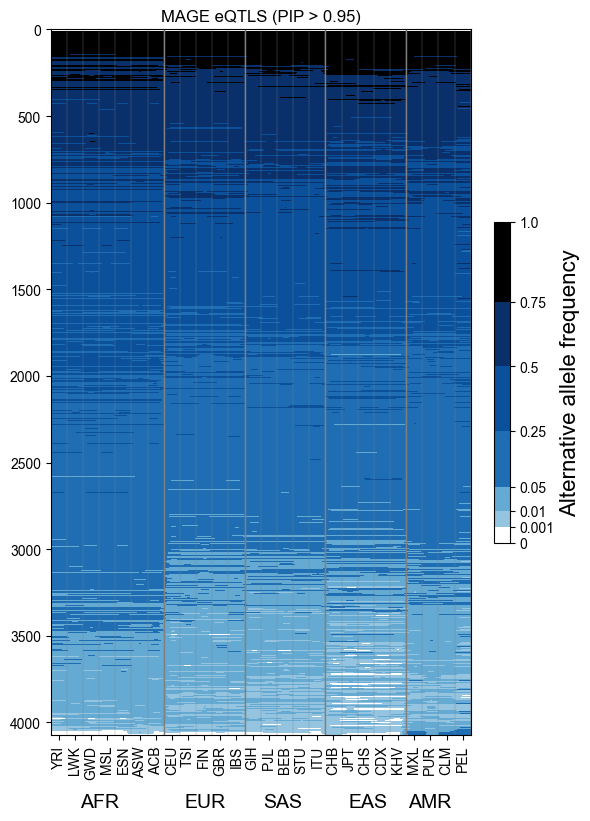

In [10]:
X_eqtl_df = merged_eqtl_af_df.filter(pl.col('variantPIP') > 0.95).select([pl.col(f'AF_{x}') for x in pops])
X = X_eqtl_df.to_numpy()
var_ids_eqtl = merged_eqtl_af_df.filter(pl.col('variantPIP') > 0.95)['variant_kgpID'].to_numpy()
print(X_eqtl_df.shape, var_ids_eqtl.shape)

mean_af_amr = np.mean(X[:, -4:], axis=1)
af_dist_amr_eqtl = np.mean((X[:, :-4].T - np.nanmean(X[:,-4:].T)).T, axis=1)

cmap = mpl.colors.ListedColormap(['white', '#94C4DF','#64AAD3', '#1F6EB3', '#0A509A', '#09306B', 'black'])
bounds = np.array([0, 1e-3, 1e-2, 0.05, 0.25, 0.5, 0.75, 1.0])
norm = mpl.colors.BoundaryNorm(bounds, cmap.N, clip=True)

fig, ax = plt.subplots(1,1,figsize=(6,8))
im = ax.imshow(X[np.argsort(af_dist_amr_eqtl)[::-1],:], aspect='auto', cmap=cmap, norm=norm)

cmap = mpl.colors.ListedColormap(['white', '#94C4DF','#64AAD3', '#1F6EB3', '#0A509A', '#09306B', 'black'])
ticklocs = [0, 0.05, 0.1, 0.175, 0.35, 0.55, 0.75, 1.0]
bounds = np.array(ticklocs)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []
cbar = fig.colorbar(sm,
                    fraction=0.035, 
                    pad=0.05,
                    shrink=0.6,
                    ax=ax,
                    spacing='proportional',
                    orientation='vertical')

# Putting in the nice vertical lines
ax.axvline(x=-0.5,color='gray', lw=0.25)
for i in range(len(pops)):
    ax.axvline(x=i+0.5,color='gray', lw=0.25)
ax.axvline(x=i+0.5,color='gray', lw=0.25)

# adding in the superpopulation lines
superpop_lns = [6, 11, 16, 21]
for i in superpop_lns:
    ax.axvline(x = i + 0.5, color='gray', lw=1.0)

# Setting x-locations for the superpopulation labels
superpop_lbls = ['AFR', 'EUR', 'SAS', 'EAS', 'AMR']
xpts_superpops = [0.175, 0.35, 0.48, 0.622, 0.725]
for i in range(len(superpop_lbls)):
    fig.text(x=xpts_superpops[i] , y=-0.01, s=superpop_lbls[i], fontsize=14,  va='center',  ha='center')

# setting the ticks + the underlying population labels
ax.set_xticks(np.arange(len(pops)))
ax.set_xticklabels(pops, fontsize=10, rotation=90)
# ax.set_yticks([]);
ax.set_title('MAGE eQTLS (PIP > 0.95)')

tick_locator = mpl.ticker.FixedLocator(locs=ticklocs)
cbar.locator = tick_locator
cbar.update_ticks()
cbar.ax.set_yticklabels([0, 1e-3, 1e-2, 0.05, 0.25, 0.5, 0.75,  1.0],fontsize=10)
cbar.set_label(label="Alternative allele frequency", fontsize=16)
plt.savefig('plots/allele_freq.eQTLs.finemap_pip95.af_AMR_diff_sorted.png', dpi=300, bbox_inches='tight')

(4075, 26) (4075,)


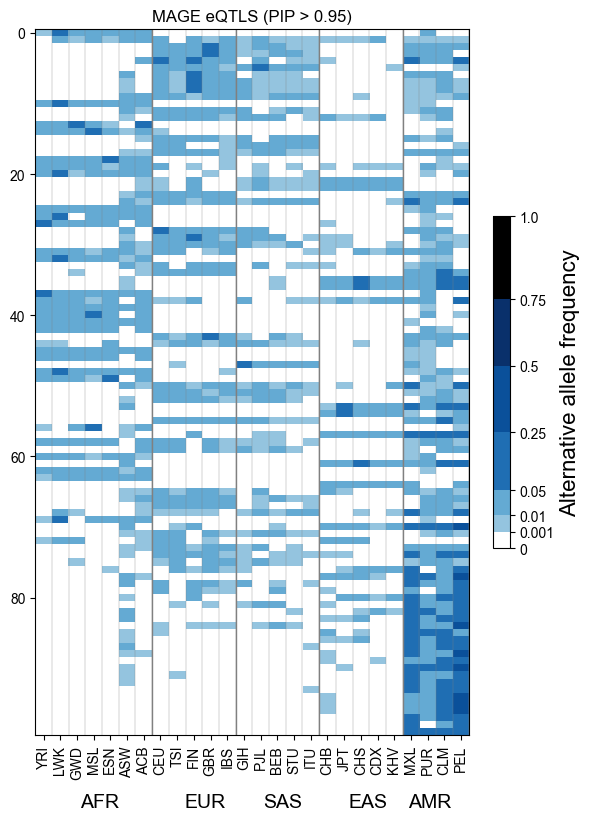

In [11]:
X_eqtl_df = merged_eqtl_af_df.filter(pl.col('variantPIP') > 0.95).select([pl.col(f'AF_{x}') for x in pops])
X = X_eqtl_df.to_numpy()
var_ids_eqtl = merged_eqtl_af_df.filter(pl.col('variantPIP') > 0.95)['variant_kgpID'].to_numpy()
print(X_eqtl_df.shape, var_ids_eqtl.shape)

mean_af_amr = np.mean(X[:, -4:], axis=1)
af_dist_amr_eqtl = np.mean((X[:, :-4].T - np.nanmean(X[:,-4:].T)).T, axis=1)

cmap = mpl.colors.ListedColormap(['white', '#94C4DF','#64AAD3', '#1F6EB3', '#0A509A', '#09306B', 'black'])
bounds = np.array([0, 1e-3, 1e-2, 0.05, 0.25, 0.5, 0.75, 1.0])
norm = mpl.colors.BoundaryNorm(bounds, cmap.N, clip=True)

fig, ax = plt.subplots(1,1,figsize=(6,8))
im = ax.imshow(X[np.argsort(af_dist_amr_eqtl)[::-1],:][-100:, :], aspect='auto', cmap=cmap, norm=norm)

cmap = mpl.colors.ListedColormap(['white', '#94C4DF','#64AAD3', '#1F6EB3', '#0A509A', '#09306B', 'black'])
ticklocs = [0, 0.05, 0.1, 0.175, 0.35, 0.55, 0.75, 1.0]
bounds = np.array(ticklocs)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []
cbar = fig.colorbar(sm,
                    fraction=0.035, 
                    pad=0.05,
                    shrink=0.6,
                    ax=ax,
                    spacing='proportional',
                    orientation='vertical')

# Putting in the nice vertical lines
ax.axvline(x=-0.5,color='gray', lw=0.25)
for i in range(len(pops)):
    ax.axvline(x=i+0.5,color='gray', lw=0.25)
ax.axvline(x=i+0.5,color='gray', lw=0.25)

# adding in the superpopulation lines
superpop_lns = [6, 11, 16, 21]
for i in superpop_lns:
    ax.axvline(x = i + 0.5, color='gray', lw=1.0)

# Setting x-locations for the superpopulation labels
superpop_lbls = ['AFR', 'EUR', 'SAS', 'EAS', 'AMR']
xpts_superpops = [0.175, 0.35, 0.48, 0.622, 0.725]
for i in range(len(superpop_lbls)):
    fig.text(x=xpts_superpops[i] , y=-0.01, s=superpop_lbls[i], fontsize=14,  va='center',  ha='center')

# setting the ticks + the underlying population labels
ax.set_xticks(np.arange(len(pops)))
ax.set_xticklabels(pops, fontsize=10, rotation=90)
# ax.set_yticks([]);
ax.set_title('MAGE eQTLS (PIP > 0.95)')

tick_locator = mpl.ticker.FixedLocator(locs=ticklocs)
cbar.locator = tick_locator
cbar.update_ticks()
cbar.ax.set_yticklabels([0, 1e-3, 1e-2, 0.05, 0.25, 0.5, 0.75,  1.0],fontsize=10)
cbar.set_label(label="Alternative allele frequency", fontsize=16)
plt.savefig('plots/allele_freq.eQTLs.finemap_pip95.af_AMR_diff_sorted.zoomed.png', dpi=300, bbox_inches='tight')

(4520, 26) (4520,)


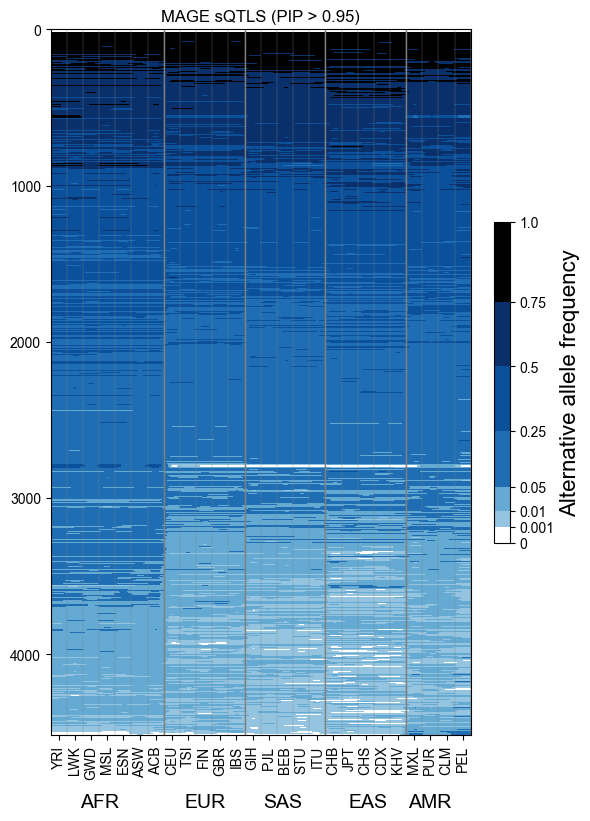

In [12]:
X_sqtl_df = merged_sqtl_af_df.filter(pl.col('intronCS_variantPIP') > 0.95).select([pl.col(f'AF_{x}') for x in pops])
# print(X_df.columns)
X = X_sqtl_df.to_numpy()
var_ids_sqtl = merged_sqtl_af_df.filter(pl.col('intronCS_variantPIP') > 0.95)['variant_kgpID'].to_numpy()
print(X_sqtl_df.shape, var_ids_sqtl.shape)

mean_af_amr = np.mean(X[:, -4:], axis=1)
af_dist_amr_sqtl = np.mean((X[:, :-4].T - np.nanmean(X[:,-4:].T)).T, axis=1)

cmap = mpl.colors.ListedColormap(['white', '#94C4DF','#64AAD3', '#1F6EB3', '#0A509A', '#09306B', 'black'])
bounds = np.array([0, 1e-3, 1e-2, 0.05, 0.25, 0.5, 0.75, 1.0])
norm = mpl.colors.BoundaryNorm(bounds, cmap.N, clip=True)

fig, ax = plt.subplots(1,1,figsize=(6,8))
im = ax.imshow(X[np.argsort(af_dist_amr_sqtl)[::-1],:], aspect='auto', cmap=cmap, norm=norm)

cmap = mpl.colors.ListedColormap(['white', '#94C4DF','#64AAD3', '#1F6EB3', '#0A509A', '#09306B', 'black'])
ticklocs = [0, 0.05, 0.1, 0.175, 0.35, 0.55, 0.75, 1.0]
bounds = np.array(ticklocs)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []
cbar = fig.colorbar(sm,
                    fraction=0.035, 
                    pad=0.05,
                    shrink=0.6,
                    ax=ax,
                    spacing='proportional',
                    orientation='vertical')

# Putting in the nice vertical lines
ax.axvline(x=-0.5,color='gray', lw=0.25)
for i in range(len(pops)):
    ax.axvline(x=i+0.5,color='gray', lw=0.25)
ax.axvline(x=i+0.5,color='gray', lw=0.25)

# adding in the superpopulation lines
superpop_lns = [6, 11, 16, 21]
for i in superpop_lns:
    ax.axvline(x = i + 0.5, color='gray', lw=1.0)

# Setting x-locations for the superpopulation labels
superpop_lbls = ['AFR', 'EUR', 'SAS', 'EAS', 'AMR']
xpts_superpops = [0.175, 0.35, 0.48, 0.622, 0.725]
for i in range(len(superpop_lbls)):
    fig.text(x=xpts_superpops[i] , y=-0.01, s=superpop_lbls[i], fontsize=14,  va='center',  ha='center')

# setting the ticks + the underlying population labels
ax.set_xticks(np.arange(len(pops)))
ax.set_xticklabels(pops, fontsize=10, rotation=90)
# ax.set_yticks([]);

ax.set_title('MAGE sQTLS (PIP > 0.95)')

tick_locator = mpl.ticker.FixedLocator(locs=ticklocs)
cbar.locator = tick_locator
cbar.update_ticks()
cbar.ax.set_yticklabels([0, 1e-3, 1e-2, 0.05, 0.25, 0.5, 0.75,  1.0],fontsize=10)
cbar.set_label(label="Alternative allele frequency", fontsize=16)
plt.savefig('plots/allele_freq.sQTLs.finemap_pip95.af_AMR_diff_sorted.png', dpi=300, bbox_inches='tight')

(4520, 26) (4520,)


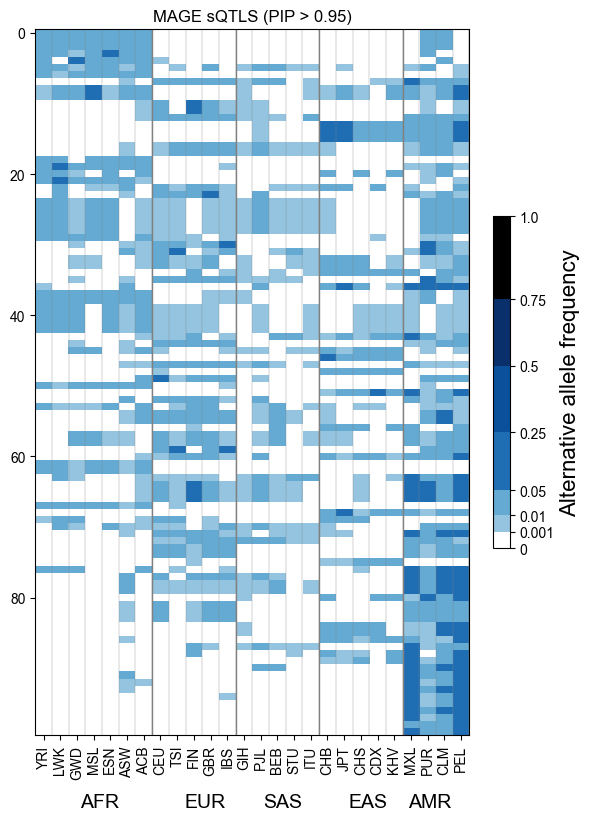

In [13]:
X_sqtl_df = merged_sqtl_af_df.filter(pl.col('intronCS_variantPIP') > 0.95).select([pl.col(f'AF_{x}') for x in pops])
# print(X_df.columns)
X = X_sqtl_df.to_numpy()
var_ids_sqtl = merged_sqtl_af_df.filter(pl.col('intronCS_variantPIP') > 0.95)['variant_kgpID'].to_numpy()
print(X_sqtl_df.shape, var_ids_sqtl.shape)

mean_af_amr = np.mean(X[:, -4:], axis=1)
af_dist_amr_sqtl = np.mean((X[:, :-4].T - np.nanmean(X[:,-4:].T)).T, axis=1)

cmap = mpl.colors.ListedColormap(['white', '#94C4DF','#64AAD3', '#1F6EB3', '#0A509A', '#09306B', 'black'])
bounds = np.array([0, 1e-3, 1e-2, 0.05, 0.25, 0.5, 0.75, 1.0])
norm = mpl.colors.BoundaryNorm(bounds, cmap.N, clip=True)

fig, ax = plt.subplots(1,1,figsize=(6,8))
im = ax.imshow(X[np.argsort(af_dist_amr_sqtl)[::-1],:][4420:,:], aspect='auto', cmap=cmap, norm=norm)

cmap = mpl.colors.ListedColormap(['white', '#94C4DF','#64AAD3', '#1F6EB3', '#0A509A', '#09306B', 'black'])
ticklocs = [0, 0.05, 0.1, 0.175, 0.35, 0.55, 0.75, 1.0]
bounds = np.array(ticklocs)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []
cbar = fig.colorbar(sm,
                    fraction=0.035, 
                    pad=0.05,
                    shrink=0.6,
                    ax=ax,
                    spacing='proportional',
                    orientation='vertical')

# Putting in the nice vertical lines
ax.axvline(x=-0.5,color='gray', lw=0.25)
for i in range(len(pops)):
    ax.axvline(x=i+0.5,color='gray', lw=0.25)
ax.axvline(x=i+0.5,color='gray', lw=0.25)

# adding in the superpopulation lines
superpop_lns = [6, 11, 16, 21]
for i in superpop_lns:
    ax.axvline(x = i + 0.5, color='gray', lw=1.0)

# Setting x-locations for the superpopulation labels
superpop_lbls = ['AFR', 'EUR', 'SAS', 'EAS', 'AMR']
xpts_superpops = [0.175, 0.35, 0.48, 0.622, 0.725]
for i in range(len(superpop_lbls)):
    fig.text(x=xpts_superpops[i] , y=-0.01, s=superpop_lbls[i], fontsize=14,  va='center',  ha='center')

# setting the ticks + the underlying population labels
ax.set_xticks(np.arange(len(pops)))
ax.set_xticklabels(pops, fontsize=10, rotation=90)
# ax.set_yticks([]);

ax.set_title('MAGE sQTLS (PIP > 0.95)')

tick_locator = mpl.ticker.FixedLocator(locs=ticklocs)
cbar.locator = tick_locator
cbar.update_ticks()
cbar.ax.set_yticklabels([0, 1e-3, 1e-2, 0.05, 0.25, 0.5, 0.75,  1.0],fontsize=10)
cbar.set_label(label="Alternative allele frequency", fontsize=16)
plt.savefig('plots/allele_freq.sQTLs.finemap_pip95.af_AMR_diff_sorted.zoomed.png', dpi=300, bbox_inches='tight')

In [14]:
for x in merged_eqtl_af_df.filter(pl.col('variant_kgpID').is_in(var_ids_eqtl[np.argsort(af_dist_amr_eqtl)[:25]]))['geneSymbol'].unique().to_numpy():
    print(x)

GMPR2
MAPK11
NUDT7
UBE2G1
SKA3
ATP8B3
LINC00339
CRELD2
ALG12
RP1-168L15.7
RP11-299H22.6
TMEM154
NFKBIL1
RP3-395M20.9
DNAJA3
CORO1A
ENPP7
PLXNB2
RP11-299H22.3
CLIP4
LTA4H
GOLGA2P11
ZFAND2A
RPS3
LINC01055
ASIC3


In [15]:
amr_enriched_eqtls_df = merged_eqtl_af_df.filter(pl.col('variant_kgpID').is_in(var_ids_eqtl[np.argsort(af_dist_amr_eqtl)[:25]])).sort('log2_aFC').drop_nulls()
amr_enriched_eqtls_df.tail()

variantChrom,variantPosition,variantRef,variantAlt,variant_kgpID,variant_rsID,ensemblID,geneSymbol,variantPIP,variantCredibleSet,log2_aFC,log2_aFC_error,log2_aFC_c0,log2_aFC_min_95_interv,log2_aFC_plus_95_interv,log2_aFC_c0_min_95_interv,log2_aFC_c0_plus_95_interv,AF_GBR,AC_GBR,AN_GBR,AF_BEB,AC_BEB,AN_BEB,AF_ASW,AC_ASW,AN_ASW,AF_PUR,AC_PUR,AN_PUR,AF_CHB,AC_CHB,AN_CHB,AF_ITU,AC_ITU,AN_ITU,AF_MSL,AC_MSL,…,AN_YRI,AF_CDX,AC_CDX,AN_CDX,AF_GWD,AC_GWD,AN_GWD,AF_IBS,AC_IBS,AN_IBS,AF_PEL,AC_PEL,AN_PEL,AF_TSI,AC_TSI,AN_TSI,AF_STU,AC_STU,AN_STU,AF_LWK,AC_LWK,AN_LWK,AF_JPT,AC_JPT,AN_JPT,AF_KHV,AC_KHV,AN_KHV,AF_PJL,AC_PJL,AN_PJL,AF_CEU,AC_CEU,AN_CEU,AF_CHS,AC_CHS,AN_CHS
str,i64,str,str,str,str,str,str,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64,f64,i64,i64,f64,i64,i64,f64,i64,i64,f64,i64,i64,f64,i64,i64,f64,i64,…,i64,f64,i64,i64,f64,i64,i64,f64,i64,i64,f64,i64,i64,f64,i64,i64,f64,i64,i64,f64,i64,i64,f64,i64,i64,f64,i64,i64,f64,i64,i64,f64,i64,i64,f64,i64,i64
"""chr16""",4345556,"""G""","""C""","""16:4345556:G:C""","""rs12924393""","""ENSG00000103423.14""","""DNAJA3""",0.999886,"""L1""",1.026311,0.054037,9.397441,0.916779,1.133346,9.37539,9.419357,0.005495,1,182,0.011628,2,172,0.0,0,122,0.0,0,208,0.004854,1,206,0.0,0,204,0.0,0,…,216,0.0,0,186,0.0,0,226,0.009346,2,214,0.064706,11,170,0.0,0,214,0.0,0,204,0.0,0,198,0.0,0,208,0.0,0,198,0.0,0,192,0.020202,4,198,0.0,0,210
"""chr1""",2577842,"""T""","""C""","""1:2577842:T:C""","""rs191100912""","""ENSG00000228037.1""","""RP3-395M20.9""",0.99997,"""L1""",1.293989,0.087183,5.055837,1.11846,1.464711,5.034338,5.077335,0.005495,1,182,0.011628,2,172,0.0,0,122,0.033654,7,208,0.0,0,206,0.0,0,204,0.0,0,…,216,0.0,0,186,0.0,0,226,0.004673,1,214,0.252941,43,170,0.0,0,214,0.004902,1,204,0.0,0,198,0.0,0,208,0.0,0,198,0.005208,1,192,0.005051,1,198,0.0,0,210
"""chr19""",1812237,"""C""","""A""","""19:1812237:C:A""","""rs549502722""","""ENSG00000130270.16""","""ATP8B3""",0.999912,"""L1""",1.628757,0.133257,3.905912,1.356976,1.891476,3.767765,4.039377,0.0,0,182,0.0,0,172,0.0,0,122,0.091346,19,208,0.0,0,206,0.0,0,204,0.0,0,…,216,0.0,0,186,0.0,0,226,0.0,0,214,0.205882,35,170,0.0,0,214,0.0,0,204,0.0,0,198,0.0,0,208,0.0,0,198,0.0,0,192,0.0,0,198,0.0,0,210
"""chr15""",62282002,"""G""","""A""","""15:62282002:G:A""","""rs143660721""","""ENSG00000261296.1""","""RP11-299H22.6""",1.0,"""L1""",2.396837,0.168316,2.618752,2.054436,2.727598,2.570262,2.667243,0.0,0,182,0.0,0,172,0.0,0,122,0.033654,7,208,0.004854,1,206,0.0,0,204,0.0,0,…,216,0.0,0,186,0.0,0,226,0.0,0,214,0.305882,52,170,0.0,0,214,0.0,0,204,0.0,0,198,0.0,0,208,0.0,0,198,0.0,0,192,0.0,0,198,0.0,0,210
"""chr15""",62282002,"""G""","""A""","""15:62282002:G:A""","""rs143660721""","""ENSG00000260062.3""","""GOLGA2P11""",1.0,"""L1""",5.786239,0.231194,1.370305,-inf,5.887984,-inf,inf,0.0,0,182,0.0,0,172,0.0,0,122,0.033654,7,208,0.004854,1,206,0.0,0,204,0.0,0,…,216,0.0,0,186,0.0,0,226,0.0,0,214,0.305882,52,170,0.0,0,214,0.0,0,204,0.0,0,198,0.0,0,208,0.0,0,198,0.0,0,192,0.0,0,198,0.0,0,210


In [16]:
merged_sqtl_af_df.filter(pl.col('variant_kgpID').is_in(var_ids_sqtl[np.argsort(af_dist_amr_sqtl)[:25]]))['geneSymbol'].unique().to_numpy()

array(['NCOA1', 'PLCL2', 'CDC42BPA', 'HLA-DRB6', 'ZNF7', 'INTS6L', 'GYPC',
       'HUS1', 'FOXM1', 'MAP4', 'CDC42SE1', 'CTD-2353F22.1', 'TMLHE',
       'TDG', 'RP11-437B10.1', 'GTF2H2', 'HLA-DRB5', 'ORMDL1', 'CHASERR',
       'SUB1', 'NBPF10', 'HLA-DRB1', 'COA1', 'NR1D1', 'NOTCH2NLA'],
      dtype=object)

In [17]:
amr_enriched_sqtls_df = merged_sqtl_af_df.filter(pl.col('variant_kgpID').is_in(var_ids_sqtl[np.argsort(af_dist_amr_sqtl)[:25]])).drop_nulls()
amr_enriched_sqtls_df.head()

variantChrom,variantPosition,variantRef,variantAlt,variant_kgpID,variant_rsID,ensemblID,geneSymbol,mergedCredibleSet,intronID,intronCredibleSet,intronCS_coverage,intronCS_variantPIP,mergedIntronSets,AF_CEU,AC_CEU,AN_CEU,AF_LWK,AC_LWK,AN_LWK,AF_TSI,AC_TSI,AN_TSI,AF_MXL,AC_MXL,AN_MXL,AF_PUR,AC_PUR,AN_PUR,AF_STU,AC_STU,AN_STU,AF_IBS,AC_IBS,AN_IBS,AF_GIH,AC_GIH,…,AN_BEB,AF_MSL,AC_MSL,AN_MSL,AF_KHV,AC_KHV,AN_KHV,AF_CLM,AC_CLM,AN_CLM,AF_ESN,AC_ESN,AN_ESN,AF_CHB,AC_CHB,AN_CHB,AF_PJL,AC_PJL,AN_PJL,AF_GBR,AC_GBR,AN_GBR,AF_CHS,AC_CHS,AN_CHS,AF_FIN,AC_FIN,AN_FIN,AF_YRI,AC_YRI,AN_YRI,AF_GWD,AC_GWD,AN_GWD,AF_JPT,AC_JPT,AN_JPT
str,i64,str,str,str,str,str,str,str,str,str,f64,f64,str,f64,i64,i64,f64,i64,i64,f64,i64,i64,f64,i64,i64,f64,i64,i64,f64,i64,i64,f64,i64,i64,f64,i64,…,i64,f64,i64,i64,f64,i64,i64,f64,i64,i64,f64,i64,i64,f64,i64,i64,f64,i64,i64,f64,i64,i64,f64,i64,i64,f64,i64,i64,f64,i64,i64,f64,i64,i64,f64,i64,i64
"""chr1""",146228413,"""T""","""C""","""1:146228413:T:C""","""rs1473799871""","""ENSG00000271425.9""","""NBPF10""","""M6""","""chr1:146189373:146228709:clu_1…","""L2""",1.0,1.0,"""chr1:146189373:146228709:clu_1…",0.005051,1,198,0.0,0,198,0.009346,2,214,0.171875,22,128,0.038462,8,208,0.0,0,204,0.009346,2,214,0.004854,1,…,172,0.0,0,170,0.0,0,198,0.170213,32,188,0.0,0,198,0.0,0,206,0.005208,1,192,0.005495,1,182,0.0,0,210,0.005051,1,198,0.0,0,216,0.0,0,226,0.0,0,208
"""chr1""",146228413,"""T""","""C""","""1:146228413:T:C""","""rs1473799871""","""ENSG00000264343.6""","""NOTCH2NLA""","""M3""","""chr1:146189373:146228709:clu_1…","""L2""",1.0,1.0,"""chr1:146189373:146228709:clu_1…",0.005051,1,198,0.0,0,198,0.009346,2,214,0.171875,22,128,0.038462,8,208,0.0,0,204,0.009346,2,214,0.004854,1,…,172,0.0,0,170,0.0,0,198,0.170213,32,188,0.0,0,198,0.0,0,206,0.005208,1,192,0.005495,1,182,0.0,0,210,0.005051,1,198,0.0,0,216,0.0,0,226,0.0,0,208
"""chr1""",227816139,"""G""","""A""","""1:227816139:G:A""","""rs146414180""","""ENSG00000143776.19""","""CDC42BPA""","""M1""","""chr1:226994980:226995650:clu_2…","""L1""",0.997884,0.997886,"""chr1:226994980:226995650:clu_2…",0.0,0,198,0.0,0,198,0.0,0,214,0.0078125,1,128,0.052885,11,208,0.0,0,204,0.0,0,214,0.004854,1,…,172,0.0,0,170,0.020202,4,198,0.010638,2,188,0.0,0,198,0.038835,8,206,0.0,0,192,0.0,0,182,0.0,0,210,0.0,0,198,0.0,0,216,0.0,0,226,0.0,0,208
"""chr2""",25174550,"""G""","""A""","""2:25174550:G:A""","""rs117485844""","""ENSG00000084676.16""","""NCOA1""","""M2""","""chr2:24731937:24739432:clu_280…","""L1""",0.997391,0.997391,"""chr2:24731937:24739432:clu_280…",0.0,0,198,0.0,0,198,0.0,0,214,0.0546875,7,128,0.0,0,208,0.004902,1,204,0.0,0,214,0.0,0,…,172,0.0,0,170,0.010101,2,198,0.010638,2,188,0.0,0,198,0.019417,4,206,0.0,0,192,0.0,0,182,0.004762,1,210,0.020202,4,198,0.0,0,216,0.0,0,226,0.004808,1,208
"""chr2""",126766464,"""T""","""C""","""2:126766464:T:C""","""rs142990781""","""ENSG00000136732.16""","""GYPC""","""M4""","""chr2:126690311:126695946:clu_2…","""L1""",0.999744,0.999744,"""chr2:126690311:126695946:clu_2…",0.010101,2,198,0.0,0,198,0.0,0,214,0.0859375,11,128,0.019231,4,208,0.0,0,204,0.018692,4,214,0.009709,2,…,172,0.0,0,170,0.0,0,198,0.058511,11,188,0.0,0,198,0.0,0,206,0.010417,2,192,0.016484,3,182,0.0,0,210,0.020202,4,198,0.0,0,216,0.0,0,226,0.0,0,208


In [18]:
for x in amr_enriched_sqtls_df['geneSymbol'].to_numpy():
    print(x)

NBPF10
NOTCH2NLA
CDC42BPA
NCOA1
GYPC
ORMDL1
MAP4
SUB1
CTD-2353F22.1
GTF2H2
HLA-DRB5
HLA-DRB6
HLA-DRB1
COA1
HUS1
ZNF7
FOXM1
TDG
CHASERR
RP11-437B10.1
NR1D1
INTS6L
TMLHE


In [19]:
amr_enriched_eqtls_df.write_csv('results/tables/mage_eqtls.finemap_pip95.amr_af_enriched.top25.tsv', separator="\t")
amr_enriched_sqtls_df.write_csv('results/tables/mage_sqtls.finemap_pip95.amr_af_enriched.top25.tsv', separator="\t")
amr_enriched_eqtls_df.head()

variantChrom,variantPosition,variantRef,variantAlt,variant_kgpID,variant_rsID,ensemblID,geneSymbol,variantPIP,variantCredibleSet,log2_aFC,log2_aFC_error,log2_aFC_c0,log2_aFC_min_95_interv,log2_aFC_plus_95_interv,log2_aFC_c0_min_95_interv,log2_aFC_c0_plus_95_interv,AF_GBR,AC_GBR,AN_GBR,AF_BEB,AC_BEB,AN_BEB,AF_ASW,AC_ASW,AN_ASW,AF_PUR,AC_PUR,AN_PUR,AF_CHB,AC_CHB,AN_CHB,AF_ITU,AC_ITU,AN_ITU,AF_MSL,AC_MSL,…,AN_YRI,AF_CDX,AC_CDX,AN_CDX,AF_GWD,AC_GWD,AN_GWD,AF_IBS,AC_IBS,AN_IBS,AF_PEL,AC_PEL,AN_PEL,AF_TSI,AC_TSI,AN_TSI,AF_STU,AC_STU,AN_STU,AF_LWK,AC_LWK,AN_LWK,AF_JPT,AC_JPT,AN_JPT,AF_KHV,AC_KHV,AN_KHV,AF_PJL,AC_PJL,AN_PJL,AF_CEU,AC_CEU,AN_CEU,AF_CHS,AC_CHS,AN_CHS
str,i64,str,str,str,str,str,str,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64,f64,i64,i64,f64,i64,i64,f64,i64,i64,f64,i64,i64,f64,i64,i64,f64,i64,…,i64,f64,i64,i64,f64,i64,i64,f64,i64,i64,f64,i64,i64,f64,i64,i64,f64,i64,i64,f64,i64,i64,f64,i64,i64,f64,i64,i64,f64,i64,i64,f64,i64,i64,f64,i64,i64
"""chr15""",62282002,"""G""","""A""","""15:62282002:G:A""","""rs143660721""","""ENSG00000166104.15""","""RP11-299H22.3""",1.0,"""L1""",-5.290953,12.294672,1.713007,-5.704499,inf,-inf,inf,0.0,0,182,0.0,0,172,0.0,0,122,0.033654,7,208,0.004854,1,206,0.0,0,204,0.0,0,…,216,0.0,0,186,0.0,0,226,0.0,0,214,0.305882,52,170,0.0,0,214,0.0,0,204,0.0,0,198,0.0,0,208,0.0,0,198,0.0,0,192,0.0,0,198,0.0,0,210
"""chr16""",77722604,"""G""","""T""","""16:77722604:G:T""","""rs182579196""","""ENSG00000140876.11""","""NUDT7""",1.0,"""L2""",-2.122757,0.337482,4.130937,-2.822493,-1.514188,4.073696,4.187829,0.0,0,182,0.0,0,172,0.0,0,122,0.019231,4,208,0.009709,2,206,0.0,0,204,0.0,0,…,216,0.005376,1,186,0.0,0,226,0.0,0,214,0.152941,26,170,0.0,0,214,0.0,0,204,0.0,0,198,0.0,0,208,0.0,0,198,0.0,0,192,0.0,0,198,0.0,0,210
"""chr17""",79733655,"""T""","""C""","""17:79733655:T:C""","""rs12453180""","""ENSG00000182156.10""","""ENPP7""",0.998367,"""L2""",-1.954787,0.342628,-0.665879,-2.719332,-1.265245,-0.771875,-0.559956,0.0,0,182,0.0,0,172,0.0,0,122,0.028846,6,208,0.0,0,206,0.0,0,204,0.0,0,…,216,0.0,0,186,0.0,0,226,0.0,0,214,0.158824,27,170,0.0,0,214,0.0,0,204,0.0,0,198,0.0,0,208,0.0,0,198,0.0,0,192,0.0,0,198,0.0,0,210
"""chr22""",50306001,"""A""","""C""","""22:50306001:A:C""","""rs35860776""","""ENSG00000196576.16""","""PLXNB2""",0.99991,"""L1""",-1.445984,0.160338,10.810727,-1.803677,-1.143802,10.797348,10.824107,0.0,0,182,0.0,0,172,0.008197,1,122,0.028846,6,208,0.004854,1,206,0.0,0,204,0.0,0,…,216,0.0,0,186,0.0,0,226,0.0,0,214,0.088235,15,170,0.0,0,214,0.0,0,204,0.0,0,198,0.004808,1,208,0.0,0,198,0.0,0,192,0.0,0,198,0.014286,3,210
"""chr6""",166343069,"""C""","""T""","""6:166343069:C:T""","""rs140020561""","""ENSG00000286760.1""","""RP1-168L15.7""",0.981984,"""L3""",-1.248753,0.174385,5.199232,-1.628461,-0.894325,5.172699,5.225746,0.0,0,182,0.0,0,172,0.0,0,122,0.0,0,208,0.0,0,206,0.0,0,204,0.0,0,…,216,0.0,0,186,0.0,0,226,0.0,0,214,0.158824,27,170,0.0,0,214,0.0,0,204,0.0,0,198,0.0,0,208,0.0,0,198,0.0,0,192,0.0,0,198,0.0,0,210
